In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
file_path = "/kaggle/input/wmt-2014-english-german/wmt14_translate_de-en_train.csv"
data = pd.read_csv(
    file_path,
    sep=',',
    quotechar='"',
    on_bad_lines='skip',
    engine='python',
    encoding='utf-8'
)

# Rename columns
data = data.rename(columns={'de': 'German', 'en': 'English'})

# Drop empty rows
data = data.dropna()

print("✅ Dataset Loaded Successfully!")
print("Total pairs loaded:", len(data))
print(data.sample(5))


✅ Dataset Loaded Successfully!
Total pairs loaded: 4508074
                                                    German  \
3726579  Beginnender Haarausfall lässt sich mit ca. 10 ...   
2015111  Die aktuelle Fassung des Anwender-Handbuches u...   
2534418  Referendum über den künftigen Status des Südsu...   
146546   Andernfalls ist der EU-Verhaltenskodex, so gut...   
834902   Nach dem Weltflüchtlingstag, der vor Kurzem st...   

                                                   English  
3726579  Beginning hair loss can be stopped with approx...  
2015111  The latest version of the User Manual refers t...  
2534418  Referendum on the future status of Southern Su...  
146546   Otherwise, the European Code of Conduct, no ma...  
834902   Following the recent World Refugee Day, let us...  


In [4]:
from sklearn.utils import shuffle
data = shuffle(data, random_state=42)

In [5]:
data = data.sample(80000, random_state=42)
print("✅ Using 80,000 English-German pairs")

✅ Using 80,000 English-German pairs


In [6]:
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation)) # Remove punctuation
    return text

data["English"] = data["English"].apply(clean_text)
data["German"] = data["German"].apply(clean_text)

# Add start and end tokens for target sentences , it help to create boundary
data["German"] = data["German"].apply(lambda x: "startseq " + x + " endseq")

In [7]:
# Tokenize -> it create a mapping dictionary where each unique word in your dataset gets assigned a unique integer ID.

eng_tokenizer = Tokenizer() # convert words (text) into numbers (tokens).
eng_tokenizer.fit_on_texts(data["English"])
eng_vocab = len(eng_tokenizer.word_index) + 1

ger_tokenizer = Tokenizer()
ger_tokenizer.fit_on_texts(data["German"])
ger_vocab = len(ger_tokenizer.word_index) + 1

# Convert to sequences -> apply Tokenize to full sentence
eng_seq = eng_tokenizer.texts_to_sequences(data["English"])
ger_seq = ger_tokenizer.texts_to_sequences(data["German"])

# Each sentence is of didderent length but neural network require fixed length (so we find max length).
max_eng_len = max(len(seq) for seq in eng_seq)
max_ger_len = max(len(seq) for seq in ger_seq)

# pad_sequences() makes all sequences equal length by adding zeros (0)
eng_seq = pad_sequences(eng_seq, maxlen=max_eng_len, padding='post') #padding='post' means zeros are added at the end
ger_seq = pad_sequences(ger_seq, maxlen=max_ger_len, padding='post')

# Split data
X_train, X_test, y_train, y_test = train_test_split(eng_seq, ger_seq, test_size=0.1, random_state=42)


In [8]:
# convert training labels into a NumPy array
y_train = np.array(y_train).squeeze()

decoder_input_data = y_train[:, :-1]
decoder_target_data = y_train[:, 1:]
decoder_target_data = np.expand_dims(decoder_target_data, -1)

In [9]:
embedding_dim = 128
latent_dim = 128

# Encoder 
# input -> embedding -> LSTM -> pass (encoder_states) to decoder LSTM
encoder_inputs = Input(shape=(max_eng_len,))
enc_emb = Embedding(eng_vocab, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True, recurrent_activation='sigmoid', use_cudnn=False)(enc_emb)
encoder_states = [state_h, state_c]

I0000 00:00:1763210415.014130      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763210415.014776      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
# Decoder
# Input -> Embedding -> LSTM -> dense (output layer) 
decoder_inputs = Input(shape=(max_ger_len - 1,))

dec_emb_layer = Embedding(ger_vocab, embedding_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, recurrent_activation='sigmoid', use_cudnn=False)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# softmax to produce probabilities for each possible German word.
decoder_dense = Dense(ger_vocab, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2018)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 486)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 2018, 128) │ 10,729,600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 2018)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 486, 128)  │ 18,813,440 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │    131,584 │ embedding[0][0],  │
│                     │ (None, 128),      │            │ not_equal[0][0]   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 486,      │    131,584 │ embedding_1[0][0… │
│                     │ 128), (None,      │            │ lstm[0][1],       │
│                     │ 128), (None,      │            │ lstm[0][2]        │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 486,       │ 18,960,420 │ lstm_1[0][0]      │
│                     │ 146980)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,766,628 (186.03 MB)

 Trainable params: 48,766,628 (186.03 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint( filepath='/kaggle/working/eng_ger_best.keras',
    monitor='val_loss', save_best_only=True,verbose=1)

earlystop = EarlyStopping(
    monitor='val_loss', patience=3,restore_best_weights=True,verbose=1)

history = model.fit(
    [X_train, decoder_input_data], decoder_target_data,batch_size=16,epochs=30,
    validation_split=0.2,callbacks=[checkpoint, earlystop],verbose=1)


Epoch 1/30


I0000 00:00:1763210419.958197     116 service.cc:148] XLA service 0x7f18a800b3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763210419.959051     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763210419.959072     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763210420.414197     116 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763210436.121429     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - loss: 7.6309
Epoch 1: val_loss improved from inf to 6.60224, saving model to /kaggle/working/eng_ger_best.keras
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 2621s 723ms/step - loss: 7.6307 - val_loss: 6.6022
Epoch 2/30
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - loss: 6.1673
Epoch 2: val_loss improved from 6.60224 to 6.33440, saving model to /kaggle/working/eng_ger_best.keras
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 2684s 746ms/step - loss: 6.1673 - val_loss: 6.3344
Epoch 3/30
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - loss: 5.5468
Epoch 3: val_loss improved from 6.33440 to 6.25143, saving model to /kaggle/working/eng_ger_best.keras
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 2697s 749ms/step - loss: 5.5467 - val_loss: 6.2514
Epoch 4/30
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - loss: 5.0504
Epoch 4: val_loss did not improve from 6.25143
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 2696s 749ms/step - loss: 5.0504 - val_loss: 6.2762
Epoch 5/30
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 68

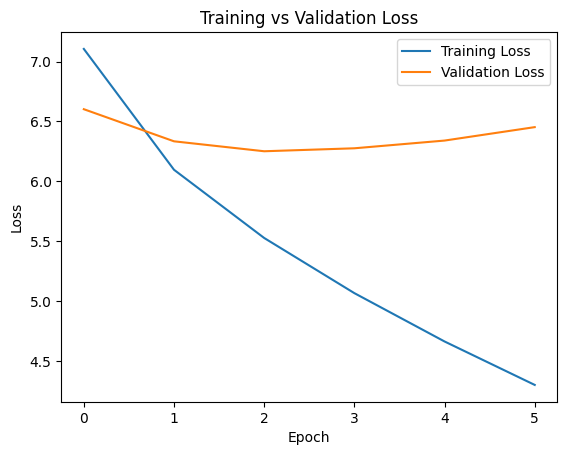

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()


In [13]:
from tensorflow.keras.models import load_model

# Load the best model (saved automatically by ModelCheckpoint) 
model = load_model('eng_ger_best.keras')
print("✅ Best trained model loaded successfully!")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


✅ Best trained model loaded successfully!


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

print("✅ Encoder–Decoder inference models ready for translation!")


2025-11-16 03:51:46.275845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763265106.516714      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763265106.585519      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

NameError: name 'encoder_inputs' is not defined

In [15]:
# Reverse-lookup dictionaries
reverse_target_index = {index: word for word, index in ger_tokenizer.word_index.items()}
reverse_source_index = {index: word for word, index in eng_tokenizer.word_index.items()}
target_index = ger_tokenizer.word_index


In [16]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def translate_sentence(input_sentence, max_translation_len=30):
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence.lower()])
    input_seq = pad_sequences(input_seq, maxlen=max_eng_len, padding='post')

    # Encode sentence to get initial states
    states_value = encoder_model.predict(input_seq)

    # Start with the 'startseq' token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_index['startseq']

    decoded_sentence = ''
    stop_condition = False
    word_count = 0

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_index.get(sampled_token_index, '')

        if (sampled_word == 'endseq' or sampled_word == '' or word_count > max_translation_len):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update target sequence and states
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
        word_count += 1

    return decoded_sentence.strip()


In [17]:
test_sentences = [
    "I am happy today",
    "She is very beautiful",
    "We are learning machine translation",
    "I love my country",
    "The weather is good"
]

print("\n🌍 English → German Translation Results:")
print("=========================================")


for sentence in test_sentences:
    translation = translate_sentence(sentence)
    translation = translation.replace("startseq", "").replace("endseq", "").strip()
    print(f"\nEnglish: {sentence}")
    print(f"German:  {translation}")



🌍 English → German Translation Results:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

English: I am happy today
German:  ich habe ihnen
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

English: She is very beautiful
German:  sie sind auf die lage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

English: We are learning machine translation
German:  wir sind uns für die zukunft

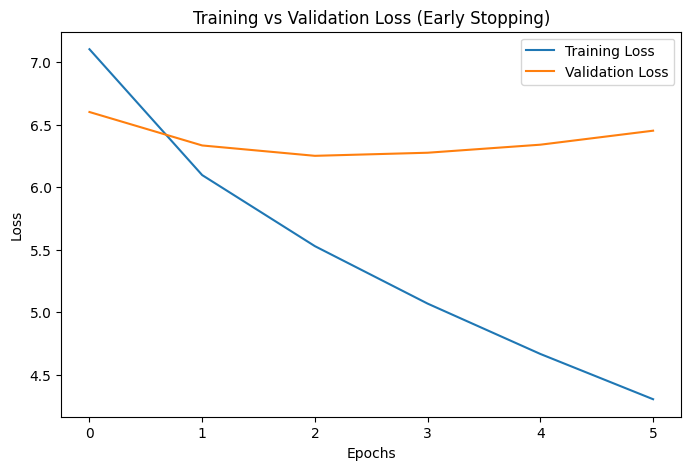

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss (Early Stopping)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
